In [1]:
import os
import pickle
import csv
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter as timer
from concurrent.futures import ProcessPoolExecutor
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker

from src import *


In [2]:
class Analysis:
    def __init__(self, gamma_max: float = 0.036, gamma_dif: float = 0.004):
        self.path_data = Data(0).path_data
        self.smp_real = np.load(self.path_data / "inputs" / "EPSIS" / "smp_2022.npy")

        self.gamma_max, self.gamma_dif = gamma_max, gamma_dif
        self.gammas = np.linspace(0, gamma_max, int(gamma_max / gamma_dif) + 1)
        self.gammas_count = len(self.gammas)
        self.gammas_color = plt.colormaps["jet"](np.linspace(0.1, 0.9, self.gammas_count))[:, :3]
        self.gammas_color_model2 = plt.colormaps["rainbow"](np.linspace(0.5, 1, self.gammas_count))[:, :3] # no reserve cost in objective
        self.gammas_color_model3 = plt.colormaps["rainbow"](np.linspace(0, 0.5, self.gammas_count))[::-1, :3] # reserve cost in objective

        self.models = ["model_1", "model_2", "model_3"]
        self.result_name = ["smps", "gammas_eff", "costs_energy", "costs_reserve", "ps_lng", "rs_lng", "ps_solar", "ps_wind", "ps_hydro"]

        self.smps = np.empty((self.gammas_count, 3, 8760)) # by gamma # by model
        self.gammas_eff = np.empty((self.gammas_count, 3, 8760))
        self.costs_energy = np.empty((self.gammas_count, 3, 8760))
        self.costs_reserve = np.empty((self.gammas_count, 3, 8760))

        self.ps_lng = np.empty((self.gammas_count, 3, 8760))
        self.rs_lng = np.empty((self.gammas_count, 3, 8760))
        self.ps_solar = np.empty((self.gammas_count, 3, 8760))
        self.ps_wind = np.empty((self.gammas_count, 3, 8760))
        self.ps_hydro = np.empty((self.gammas_count, 3, 8760))
        for idx_name, name in enumerate(self.result_name):
            self._load_results(idx_name, name)
        self.costs_total = self.costs_energy + self.costs_reserve
        self.costs_energy *= 1000 
        self.costs_reserve *= 1000 
        self.costs_total *= 1000 

    
    def _load_results(self, idx_name: int, name: str):
        file_name =  ["smp", "gammas_eff", "cost_energy", "cost_reserve", "p_lng", "r_lng", "p_solar", "p_wind", "p_hydro"]
        for idx_gamma, gamma in enumerate(self.gammas):
            for idx_model, model in enumerate(self.models):

                if name in ["ps_lng", "rs_lng", "ps_solar", "ps_wind", "ps_hydro"]:
                    eval(f"self.{name}")[idx_gamma, idx_model] = np.load(self.path_data / "outputs" / f"{gamma}" / f"{model}" / f"{file_name[idx_name]}.npy").sum(axis=1)
                else:                
                    eval(f"self.{name}")[idx_gamma, idx_model] = np.load(self.path_data / "outputs" / f"{gamma}" / f"{model}" / f"{file_name[idx_name]}.npy")


    def style_plot(self, ax, tick_size=20):
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_linewidth(1)
        ax.spines['left'].set_linewidth(1)
        ax.grid(False)

        ax.tick_params(axis='x', labelsize=tick_size, direction='in')
        ax.tick_params(axis='y', labelsize=tick_size, direction='in')


        ax.figure.canvas.draw()  


In [3]:
ana = Analysis()
data = Data(0)
demand = Demand(data)
con = Conventional(data)
ren = Renewable(data)

In [16]:
idx_hour_start, idx_hour_end = data.idx_hour_month_start[0], data.idx_hour_month_start[0] # same month
idx_hour_start += 24 * 33
idx_hour_end += idx_hour_start + 23  # inclusive end
# idx_hour_start, idx_hour_end = data.idx_hour_month_start[0], data.idx_hour_month_end[0] # inclusive end
iterator = range(idx_hour_start, idx_hour_end+1)

xtick_label = np.array([1, 9 ,19, 24])
xtick = xtick_label - 1 + idx_hour_start

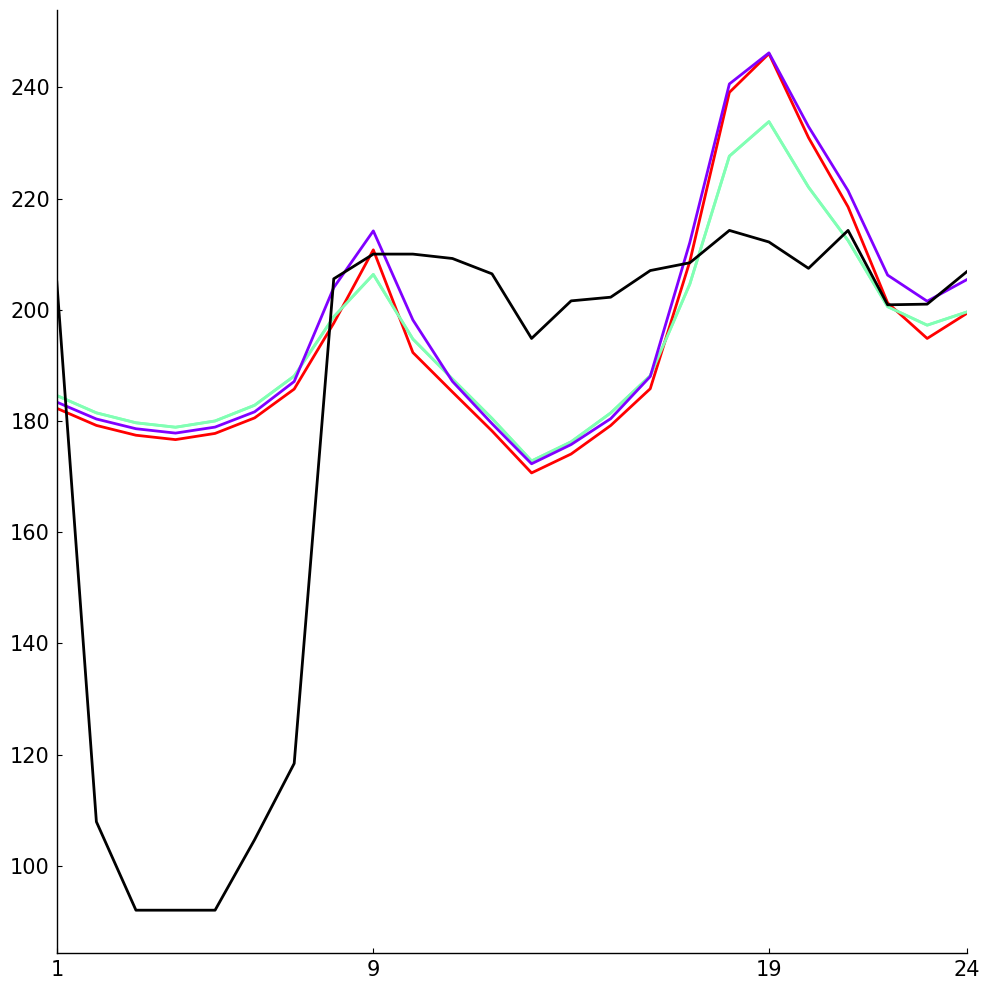

In [17]:
linewidth = 2
alpha = 1
gammas_interval = 9

idx_gamma_interval = list(range(0, ana.gammas_count + gammas_interval, gammas_interval))


fig, ax1 = plt.subplots(1, 1, figsize=(10, 10))


for idx_gamma, smp in enumerate(ana.smps[:, 1, idx_hour_start:idx_hour_end+1]):
    if idx_gamma in idx_gamma_interval:
        ax1.plot(iterator, smp, color=ana.gammas_color_model2[idx_gamma], linewidth=linewidth, label=f"model 2 - {ana.gammas[idx_gamma]}", alpha=alpha)


for idx_gamma, smp in enumerate(ana.smps[:, 2, idx_hour_start:idx_hour_end+1]):
    if idx_gamma in idx_gamma_interval:
        ax1.plot(iterator, smp, color=ana.gammas_color_model3[idx_gamma], linewidth=linewidth, label=f"model 3 - {ana.gammas[idx_gamma]}", alpha=alpha)


ax1.plot(iterator, ana.smp_real[idx_hour_start:idx_hour_end+1], color="black", linewidth=linewidth, label=f"smp_real", alpha=alpha)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.tick_params(axis='both', labelsize=15, direction='in')
ax1.spines['bottom'].set_linewidth(1)
ax1.spines['left'].set_linewidth(1)


ax1.set_xlim((idx_hour_start, idx_hour_end))
ax1.tick_params(axis="both", pad=5)
ax1.set_xticks(xtick)
ax1.set_xticklabels(xtick_label)
# ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x}.split('))

# ax1.set_ylim(0)
# ax.legend()
fig.tight_layout()
plt.show(fig)

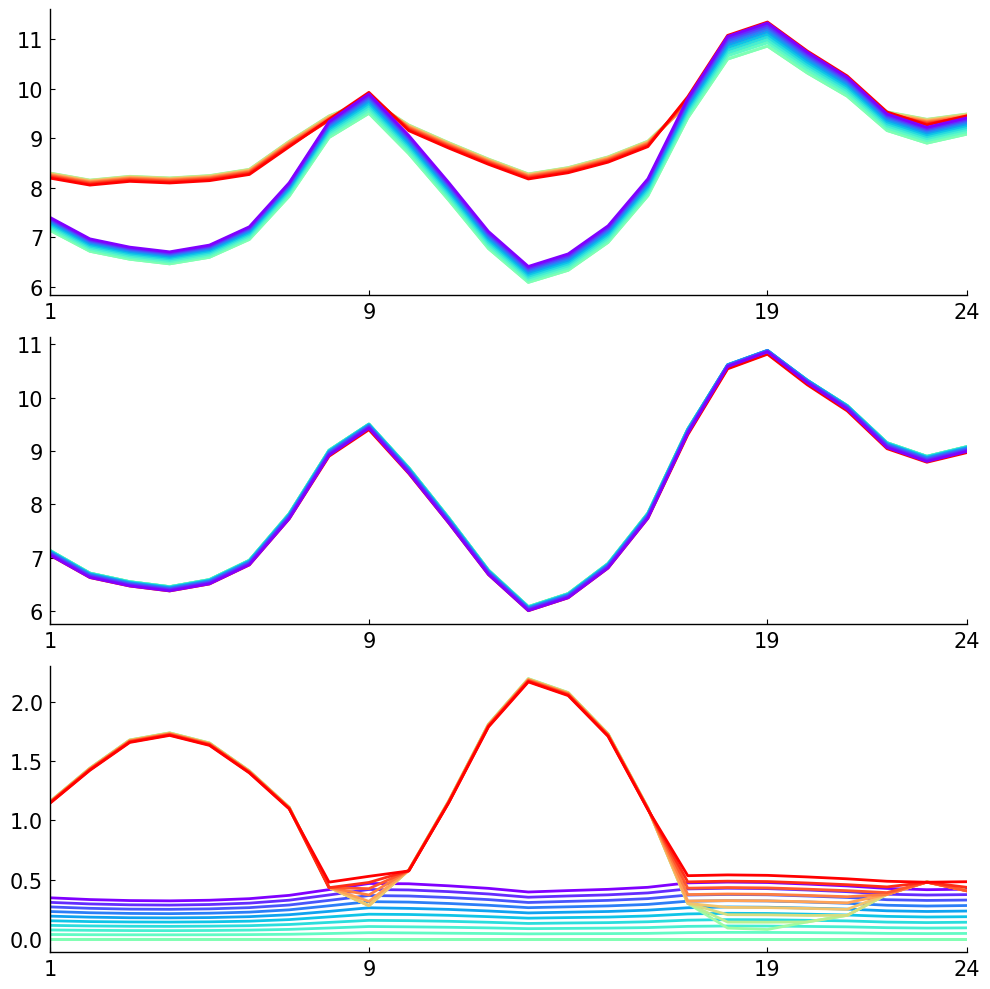

In [24]:
linewidth = 2
alpha = 1

fig, axes = plt.subplots(3, 1, figsize=(10, 10))
ax1, ax2, ax3 = axes

# ALL BN KRW
for idx_gamma, cost_energy in enumerate(ana.costs_energy[:, 1, idx_hour_start:idx_hour_end+1] / 1e9):
    ax2.plot(iterator, cost_energy, color=ana.gammas_color_model2[idx_gamma], linewidth=linewidth, label=f"model 2 - {ana.gammas[idx_gamma]}", alpha=alpha)
for idx_gamma, cost_energy in enumerate(ana.costs_energy[:, 2, idx_hour_start:idx_hour_end+1] / 1e9):
    ax2.plot(iterator, cost_energy, color=ana.gammas_color_model3[idx_gamma], linewidth=linewidth, label=f"model 3 - {ana.gammas[idx_gamma]}", alpha=alpha)

for idx_gamma, cost_reserve in enumerate(ana.costs_reserve[:, 2, idx_hour_start:idx_hour_end+1] / 1e9):
    ax3.plot(iterator, cost_reserve, color=ana.gammas_color_model3[idx_gamma], linewidth=linewidth, label=f"model 3 - {ana.gammas[idx_gamma]}", alpha=alpha)
for idx_gamma, cost_reserve in enumerate(ana.costs_reserve[:, 1, idx_hour_start:idx_hour_end+1] / 1e9):
    ax3.plot(iterator, cost_reserve, color=ana.gammas_color_model2[idx_gamma], linewidth=linewidth, label=f"model 2 - {ana.gammas[idx_gamma]}", alpha=alpha)

for idx_gamma, cost_total in enumerate(ana.costs_total[:, 1, idx_hour_start:idx_hour_end+1] / 1e9):
    ax1.plot(iterator, cost_total, color=ana.gammas_color_model2[idx_gamma], linewidth=linewidth, label=f"model 2 - {ana.gammas[idx_gamma]}", alpha=alpha)
for idx_gamma, cost_total in enumerate(ana.costs_total[:, 2, idx_hour_start:idx_hour_end+1] / 1e9):
    ax1.plot(iterator, cost_total, color=ana.gammas_color_model3[idx_gamma], linewidth=linewidth, label=f"model 3 - {ana.gammas[idx_gamma]}", alpha=alpha)

for ax in axes:
    ana.style_plot(ax, tick_size=15)
    ax.set_xlim((idx_hour_start, idx_hour_end))
    ax.tick_params(axis="both", pad=5)
    ax.set_xticks(xtick)
    ax.set_xticklabels(xtick_label)
#     ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-9:.1f}'))

# ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: str(int(x)) if x == int(x) else str(int(x))))
# ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, _: str(int(x)) if x == int(x) else str(int(x))))


# ax3.set_ylim(0)

# ax.legend()
fig.tight_layout()
plt.show(fig)

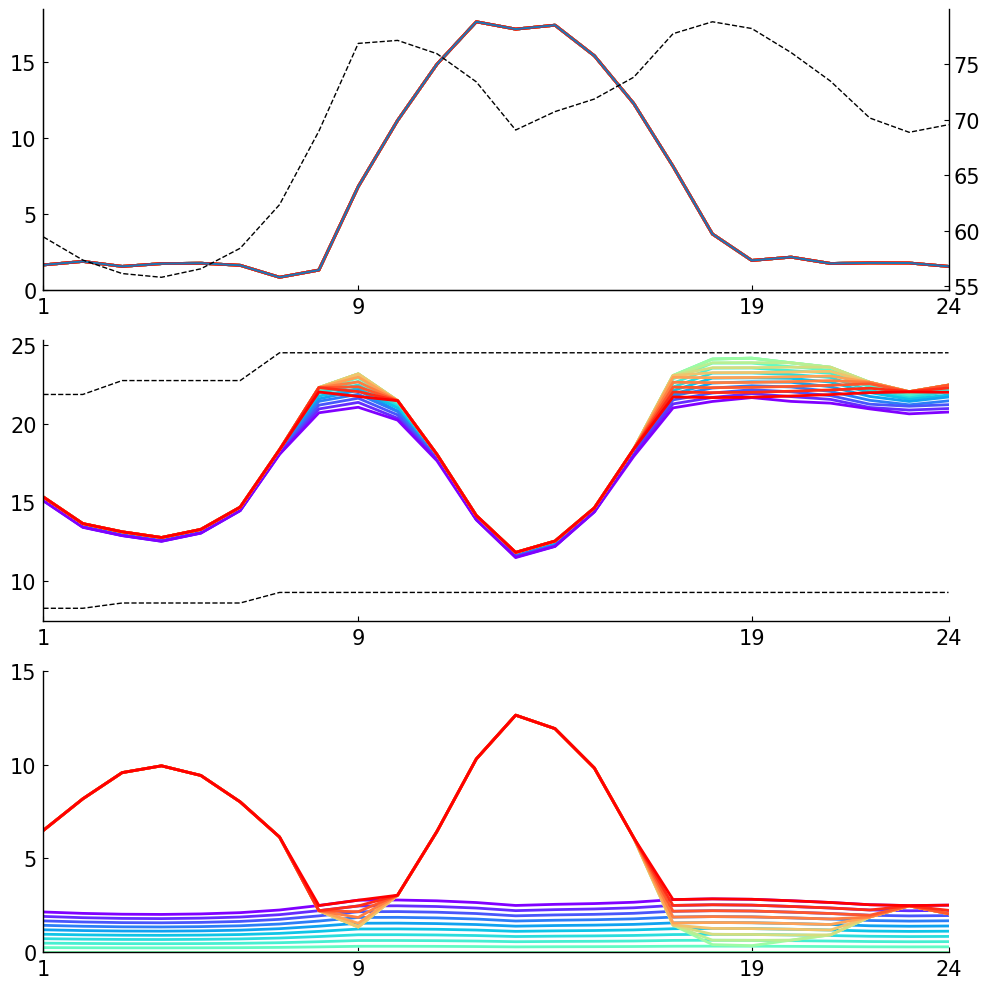

In [29]:
fig, axes = plt.subplots(3, 1, figsize=(10, 10))
ax1, ax2, ax3 = axes

ax1tx = ax1.twinx()
# GW
ax1tx.plot(iterator, demand.total[idx_hour_start:idx_hour_end+1] / 1000, color="black", linewidth=linewidth/2, linestyle="--", label="demand")

# GW
ren_ps_total = ana.ps_solar + ana.ps_wind + ana.ps_hydro
for idx_gamma, ren_p_total in enumerate(ren_ps_total[:, 2, idx_hour_start:idx_hour_end+1]):
    ax1.plot(iterator, ren_p_total / 1000, color=ana.gammas_color_model3[idx_gamma], linewidth=linewidth, label=f"model 3 - {ana.gammas[idx_gamma]}", alpha=alpha)
for idx_gamma, ren_p_total in enumerate(ren_ps_total[:, 1, idx_hour_start:idx_hour_end+1]):
    ax1.plot(iterator, ren_p_total / 1000, color=ana.gammas_color_model2[idx_gamma], linewidth=linewidth, label=f"model 2 - {ana.gammas[idx_gamma]}", alpha=alpha)

# REN PMAX
ren_total_pmax = ren.solar.pmax.sum(axis=1) + ren.wind.pmax.sum(axis=1) + ren.hydro.pmax.sum(axis=1)
ren_total_pmax_target = ren_total_pmax[idx_hour_start:idx_hour_end+1]
ax1.plot(iterator, ren_total_pmax_target/1000)




# LNG P LNG (SUMMED ALL UNIT)
for idx_gamma, ana.p_lng in enumerate(ana.ps_lng[:, 2, idx_hour_start:idx_hour_end+1]):
    ax2.plot(iterator, ana.p_lng / 1000, color=ana.gammas_color_model3[idx_gamma], linewidth=linewidth, label=f"model 3 - {ana.gammas[idx_gamma]}", alpha=alpha)
for idx_gamma, ana.p_lng in enumerate(ana.ps_lng[:, 1, idx_hour_start:idx_hour_end+1]):
    ax2.plot(iterator, ana.p_lng / 1000, color=ana.gammas_color_model2[idx_gamma], linewidth=linewidth, label=f"model 2 - {ana.gammas[idx_gamma]}", alpha=alpha)


# LNG PMAX PMIN
lng_total_pmax = con.lng.pmax.sum(axis=1)
lng_total_pmax_target = lng_total_pmax[idx_hour_start:idx_hour_end+1]
ax2.plot(iterator, lng_total_pmax_target / 1000, linestyle="--", linewidth=linewidth / 2, color="black")

lng_total_pmin = con.lng.pmin.sum(axis=1)
lng_total_pmin_target = lng_total_pmin[idx_hour_start:idx_hour_end+1]
ax2.plot(iterator, lng_total_pmin_target / 1000, linestyle="--", linewidth=linewidth / 2, color="black")


# GW
for idx_gamma, r_lng in enumerate(ana.rs_lng[:, 2, idx_hour_start:idx_hour_end+1]):
    ax3.plot(iterator, r_lng / 1000, color=ana.gammas_color_model3[idx_gamma], linewidth=linewidth, label=f"model 3 - {ana.gammas[idx_gamma]}", alpha=alpha)
for idx_gamma, r_lng in enumerate(ana.rs_lng[:, 1, idx_hour_start:idx_hour_end+1]):
    ax3.plot(iterator, r_lng / 1000, color=ana.gammas_color_model2[idx_gamma], linewidth=linewidth, label=f"model 2 - {ana.gammas[idx_gamma]}", alpha=alpha)



for ax in axes:
    ana.style_plot(ax, tick_size=15)
    ax.set_xlim((idx_hour_start, idx_hour_end))
    ax.tick_params(axis="both", pad=5)
    ax.set_xticks(xtick)
    ax.set_xticklabels(xtick_label)
    
ax1tx.spines['top'].set_visible(False)
ax1tx.spines['right'].set_linewidth(1)
ax1tx.tick_params(axis='y', labelsize=15, direction='in')

yticks = ax3.get_yticks()
ax3.set_yticks(yticks) 
ax3.set_yticklabels([str(int(t)) for t in yticks])

ax3.set_ylim(0)
fig.tight_layout()
plt.show(fig)

In [8]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
# # for monthly plots
# month_names = {0: "January", 1: "February", 2: "March", 3: "April", 4: "May", 5: "June", 6: "July", 7: "August", 8: "September", 9: "October", 10: "November", 11: "December"}
# idxs_hour_month_start = np.array([0, 744, 1416, 2160, 2880, 3624, 4344, 5088, 5832, 6552, 7296, 8016])
# idxs_hour_month_end = np.concatenate((np.delete(idxs_hour_month_start, 0), np.array([8760]))) - 1
# iterators_month = [range(start, (end + 1)) for start, end in zip(idxs_hour_month_start, idxs_hour_month_end)]
# days_in_months = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
# # np.searchsorted(idxs_hour_month_start, idx_hour, side='right') - 1 # returns 0-index month given idx_hour

# # for day plots
# day_names = {0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
# days_of_year = (np.arange(8760) // 24 + 5) % 7
# days_cmap = days_cmap = [plt.colormaps["jet_r"](i / 6) for i in range(7)]



In [ ]:
# from copy import deepcopy
# result_3_reserve = deepcopy(result_3.smp)

In [ ]:
# OLD COMMENT DOESNT REFLECT CURRENT MODEL
# idx_hour_spc_start, idx_hour_spc_end = idxs_hour_month_start[0], idxs_hour_month_end[0]
# iterator = range(idx_hour_spc_start, (idx_hour_spc_end + 1))

# fig, ax1 = plt.subplots(1, 1, figsize=(30, 10))
# ax2 = ax1.twinx()
# # SMP
# l0, = ax1.plot(iterator, smp_real[idx_hour_spc_start:idx_hour_spc_end+1], color="blue", label="SMP - KPX", linewidth=1)
# l1, = ax1.plot(iterator, result_2.smp[idx_hour_spc_start:idx_hour_spc_end+1], color="red", label="SMP - GYEONGMIN", linewidth=3)
# # l1, = ax1.plot(iterator, result_3_reserve.smp[idx_hour_spc_start:idx_hour_spc_end+1], color="green", label="SMP - GYEONGMIN", linewidth=1, linestyle="--")
# l1, = ax1.plot(iterator, result_3.smp[idx_hour_spc_start:idx_hour_spc_end+1], color="black", label="SMP - GYEONGMIN", linewidth=1, linestyle="--")

# # MONTH
# ymin, ymax = ax1.get_ylim()
# ymin = ymin if result_2.smp[idx_hour_spc_start:idx_hour_spc_end+1].min() < 0 else 0
# l3= ax1.vlines(x=idxs_hour_month_start.tolist() + [idxs_hour_month_end[-1]], ymin=ymin, ymax=ymax, colors="black", linewidth=2, linestyles="--", label="New Month")
# # TITLE
# ax1.set_title("Historical and Computed Hourly SMP, and Monthly LNG Price for GENCOs and IPPs in 2022",
#               fontsize=30, loc='left')
# ax1.set_xlabel("Month", fontsize=30)
# ax1.set_ylabel("System Marginal Price (KRW/kWh)", fontsize=30)
# # ax2.set_ylabel("LNG Price (KRW/GJ)", fontsize=30)
# # TICKS
# ax1.set_xticks(((idxs_hour_month_start + idxs_hour_month_end) / 2).tolist())
# ax1.set_xticklabels(list(month_names.values()))
# ax1.tick_params(axis='both', labelsize=20)
# [label.set_rotation(90) or label.set_va('center') for label in ax1.get_yticklabels()]
# [label.set_rotation(90) or label.set_va('center') or label.set_fontsize(20) for label in ax2.get_yticklabels()]
# # LEGEND
# lines = [l0, l1, l3]
# # ax1.legend(lines, [line.get_label() for line in lines], loc="upper left", fontsize=20)
# # LIM
# ax1.set_xlim((idx_hour_spc_start - 0.5, idx_hour_spc_end + .5))
# ax1.set_ylim((ymin, ymax))
# ax2.set_ylim((0, 54000))


# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax2.spines['top'].set_visible(False)


# fig.tight_layout()
# plt.show(fig) # LNG price is basically for justification of the method for tuning (development of method 2) # why it's sensible to scale the LNG's C1 by alpha (below)